In [116]:
import os, time
from collections import deque
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

%matplotlib inline

In [117]:
def load_sales(parse_date = True):
    data_fol = 'data'
    sales = pd.read_csv(os.path.join(data_fol, 'sales_train.csv'))
    if parse_date:
        date_col = pd.to_datetime(sales.date, format='%d.%m.%Y')
        sales.date = date_col
        sales['Month'] = sales.date.dt.to_period('M')
    return sales

def aggregate_monthly(sales_df):
    assert 'Month' in sales_df.columns, 'Month column not found'
    return (sales_df
            .groupby(['Month', 'shop_id', 'item_id'])
            .agg({'item_cnt_day': np.sum, 'item_price': np.mean})
            .rename(columns={'item_cnt_day':'item_cnt_month'})
           )

In [118]:
def load_all():
    sales = load_sales()
    agg_sales = aggregate_monthly(sales)
    items = pd.read_csv('data/items.csv')
    categories = pd.read_csv('data/item_categories.csv')
    test_set = pd.read_csv('data/test.csv')
    return sales, agg_sales, items, categories, test_set

In [119]:
def create_submission_like_df():
    months = sorted(agg_sales.index.levels[0])
    submission_like_data  = {}
    for month in months:    
        month_data = agg_sales.loc[month]
        shops = set(month_data.index.get_level_values(0))
        item_ids = set(month_data.index.get_level_values(1))

        new_idx = pd.Index(product(shops, item_ids), name=month_data.index.name)
        submission_like_data[month] = month_data.reindex(new_idx).fillna({'item_cnt_month':0, 'item_price':-1})
        
    submission_like_df = pd.concat(submission_like_data)
    submission_like_df.index.names = agg_sales.index.names
    
    return submission_like_df

In [120]:
sales, agg_sales, items, categories, test_set = load_all()

In [121]:
agg_sales = agg_sales.drop(6066, level=2)

In [122]:
agg_sales.loc[agg_sales.item_price <= 0.1, 'item_price'] = np.nan
agg_sales['item_price'] = agg_sales.groupby(level=2).item_price.transform(lambda x: x.fillna(x.mean()))

In [123]:
cat_annotated_agg_sales = (pd.merge(agg_sales.reset_index(), items.drop('item_name', axis=1), on='item_id')
                           .set_index(['Month', 'shop_id', 'item_id'])
                           .sort_index(level=[0,1,2])
                          )

In [124]:
submission_like_df = create_submission_like_df()

In [125]:
months = sorted(agg_sales.index.levels[0])

In [126]:
piv_agg_sales = agg_sales.item_cnt_month.unstack(level=0).fillna(0).sort_index()

In [127]:
piv_agg_sales.head()

Month            2013-01  2013-02  2013-03  2013-04  2013-05  2013-06  \
shop_id item_id                                                         
0       30           0.0     31.0      0.0      0.0      0.0      0.0   
        31           0.0     11.0      0.0      0.0      0.0      0.0   
        32           6.0     10.0      0.0      0.0      0.0      0.0   
        33           3.0      3.0      0.0      0.0      0.0      0.0   
        35           1.0     14.0      0.0      0.0      0.0      0.0   

Month            2013-07  2013-08  2013-09  2013-10  ...  2015-01  2015-02  \
shop_id item_id                                      ...                     
0       30           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        31           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        32           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        33           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        35           0.0      0.0      0.0      0.0  ...      0.0      0.0   

Month            2015-03  2015-04  2015-05  2015-06  2015-07  2015-08  \
shop_id item_id                                                         
0       30           0.0      0.0      0.0      0.0      0.0      0.0   
        31           0.0      0.0      0.0      0.0      0.0      0.0   
        32           0.0      0.0      0.0      0.0      0.0      0.0   
        33           0.0      0.0      0.0      0.0      0.0      0.0   
        35           0.0      0.0      0.0      0.0      0.0      0.0   

Month            2015-09  2015-10  
shop_id item_id                    
0       30           0.0      0.0  
        31           0.0      0.0  
        32           0.0      0.0  
        33           0.0      0.0  
        35           0.0      0.0  

[5 rows x 34 columns]

In [128]:
shop_items = piv_agg_sales.iloc[:,:24].sum(axis=1).unstack(level=1).fillna(0)

In [129]:
shop_cat = cat_annotated_agg_sales.reset_index().groupby(['shop_id', 'item_category_id']).item_cnt_month.sum().unstack(level=1).fillna(0)

In [130]:
shop_cat.head()

item_category_id,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
shop_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,105.0,52.0,38.0,63.0,144.0,0.0,0.0,0.0,...,0.0,338.0,0.0,120.0,0.0,0.0,0.0,44.0,146.0,86.0
1,0.0,0.0,63.0,18.0,30.0,25.0,66.0,0.0,0.0,0.0,...,0.0,132.0,0.0,68.0,0.0,0.0,0.0,28.0,169.0,64.0
2,0.0,0.0,355.0,527.0,42.0,50.0,329.0,76.0,4.0,0.0,...,0.0,512.0,0.0,36.0,0.0,222.0,0.0,2.0,70.0,51.0
3,0.0,0.0,200.0,360.0,28.0,107.0,254.0,63.0,100.0,0.0,...,0.0,156.0,0.0,13.0,0.0,252.0,99.0,0.0,0.0,56.0
4,0.0,0.0,309.0,333.0,101.0,156.0,337.0,46.0,6.0,0.0,...,0.0,781.0,0.0,106.0,0.0,501.0,5.0,31.0,380.0,70.0


In [81]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [108]:
tsne = TSNE(perplexity=6).fit_transform(shop_cat)

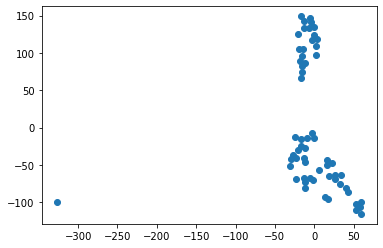

In [109]:
plt.scatter(tsne[:,0], tsne[:,1])

In [111]:
kmeans = KMeans(n_clusters=3).fit(shop_cat)

In [112]:
pd.Series(kmeans.labels_).value_counts()

0    33
1    22
2     5
dtype: int64

In [113]:
shop_cat = shop_cat.set_index(kmeans.labels_, append=True)

In [114]:
shop_cat.head()

,item_category_id,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
shop_id,,,,,,,,,,,,,,,,,,,,,,
0,1,1.0,1.0,105.0,52.0,38.0,63.0,144.0,0.0,0.0,0.0,...,0.0,338.0,0.0,120.0,0.0,0.0,0.0,44.0,146.0,86.0
1,1,0.0,0.0,63.0,18.0,30.0,25.0,66.0,0.0,0.0,0.0,...,0.0,132.0,0.0,68.0,0.0,0.0,0.0,28.0,169.0,64.0
2,1,0.0,0.0,355.0,527.0,42.0,50.0,329.0,76.0,4.0,0.0,...,0.0,512.0,0.0,36.0,0.0,222.0,0.0,2.0,70.0,51.0
3,1,0.0,0.0,200.0,360.0,28.0,107.0,254.0,63.0,100.0,0.0,...,0.0,156.0,0.0,13.0,0.0,252.0,99.0,0.0,0.0,56.0
4,0,0.0,0.0,309.0,333.0,101.0,156.0,337.0,46.0,6.0,0.0,...,0.0,781.0,0.0,106.0,0.0,501.0,5.0,31.0,380.0,70.0


In [115]:
shop_cat.groupby(level=1).mean()

item_category_id,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
0,0.030303,0.030303,389.212121,572.575758,51.484848,149.939394,406.363636,99.454545,78.757576,0.000000,...,0.000000,1002.787879,0.000000,77.030303,0.000000,350.909091,49.030303,19.848485,242.696970,238.212121
1,0.045455,0.045455,79.363636,145.409091,9.136364,28.000000,81.500000,35.181818,410.636364,823.545455,...,2.681818,195.090909,256.681818,24.818182,115.954545,62.000000,139.000000,4.000000,37.727273,31.954545
2,0.200000,0.000000,1001.400000,1542.600000,101.400000,369.800000,1053.800000,260.400000,413.200000,0.000000,...,0.000000,2167.800000,0.000000,162.400000,0.000000,577.200000,292.000000,44.400000,319.600000,693.600000


In [147]:
temp = piv_agg_sales.sum(axis=1).unstack(level=0).fillna(0).T

In [148]:
from sklearn.decomposition import TruncatedSVD

In [151]:
%%time
tsvd = TruncatedSVD(n_components=100).fit_transform(temp)

Wall time: 399 ms


In [152]:
tsvd.shape

(60, 60)

In [155]:
pd.DataFrame(tsvd, index=temp.index)

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
shop_id,,,,,,,,,,,,,,,,,,,,,
0,41.787757,-3.765386,0.000510,116.730019,85.771138,46.143274,-53.914832,-3.830626,68.167730,-11.822513,...,-5.723700,-35.666543,-1.451453,15.141985,-4.413709e+00,-14.077507,-39.722531,-5.078800,6.689580e-02,-1.608974e-02
1,22.231387,-1.673456,0.000140,72.901469,54.444963,38.862555,-42.522771,-15.814922,33.386857,0.613062,...,4.075585,-11.444784,-1.504917,11.460488,4.034524e+00,33.191893,87.585111,-9.601857,1.409125e-01,6.642212e-03
2,1522.180080,29.047102,-0.013186,487.200774,-55.105461,-272.030797,67.906120,-168.909885,-83.066576,-32.100786,...,-8.350464,-6.797101,-6.077451,-2.843536,-3.113607e+00,3.219754,-1.322776,0.401879,-1.528772e-01,4.939646e-02
3,1321.096376,2.286660,-0.005138,387.983746,12.200134,-163.130644,32.311036,12.305696,-37.095921,18.220876,...,3.807061,28.124960,-15.836608,9.395913,-1.371722e+01,7.801048,-1.671381,-0.472670,1.527535e-01,1.842125e-02
4,2704.869962,-51.573481,0.003570,556.147029,43.148352,14.021462,182.268111,175.715442,-88.016219,-20.834060,...,17.374918,-0.875195,7.125694,0.149704,3.549039e+00,-0.362596,-1.134215,0.472148,8.909193e-02,7.003346e-03
5,2360.346091,-35.546939,0.002754,302.388548,72.878033,-184.392003,55.668566,45.723308,-131.064843,-0.743903,...,7.157044,-1.631731,-4.416237,4.615303,-2.399257e+00,0.042923,-1.544296,-0.109223,1.000786e-01,-1.918682e-02
6,4093.185627,15.306237,-0.021514,1183.744061,-461.613617,206.950396,-314.740399,20.688626,-56.194847,-45.672150,...,8.215653,-7.058487,-2.824998,0.279572,-1.495158e+00,0.145784,0.500264,0.536115,6.765034e-02,-1.845538e-03
7,3667.077098,-52.695787,0.001480,706.101121,58.243755,-208.299513,209.975007,120.717821,-174.374011,26.977712,...,-7.593726,-0.379950,-1.075824,-3.250100,5.422954e-01,-1.611289,-0.614496,-0.734283,6.867911e-02,1.060614e-02
8,16.725320,0.043955,-0.000222,44.673042,12.052806,7.083294,-17.027211,20.485390,31.168705,-5.048537,...,-0.506861,7.221059,-0.766780,7.874127,1.209167e+00,-0.238654,9.403623,74.990073,-2.658948e-01,4.402068e-02


In [154]:
temp.head()

item_id,0,1,2,3,4,5,6,7,8,9,...,22160,22161,22162,22163,22164,22165,22166,22167,22168,22169
shop_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,18.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,7.0,0.0,0.0,5.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0


In [156]:
cat_annotated_agg_sales

item_cnt_month  item_price  item_category_id
Month   shop_id item_id                                              
2013-01 0       32                  6.0       221.0                40
                33                  3.0       347.0                37
                35                  1.0       247.0                40
                43                  1.0       221.0                40
                51                  2.0       128.5                57
...                                 ...         ...               ...
2015-10 59      22087               6.0       119.0                83
                22088               2.0       119.0                83
                22091               1.0       179.0                83
                22100               1.0       629.0                42
                22102               1.0      1250.0                42

[1609123 rows x 3 columns]

In [157]:
piv_agg_sales

Month            2013-01  2013-02  2013-03  2013-04  2013-05  2013-06  \
shop_id item_id                                                         
0       30           0.0     31.0      0.0      0.0      0.0      0.0   
        31           0.0     11.0      0.0      0.0      0.0      0.0   
        32           6.0     10.0      0.0      0.0      0.0      0.0   
        33           3.0      3.0      0.0      0.0      0.0      0.0   
        35           1.0     14.0      0.0      0.0      0.0      0.0   
...                  ...      ...      ...      ...      ...      ...   
59      22154        1.0      0.0      0.0      0.0      0.0      0.0   
        22155        0.0      0.0      0.0      0.0      0.0      0.0   
        22162        0.0      0.0      0.0      0.0      0.0      0.0   
        22164        0.0      0.0      0.0      0.0      0.0      0.0   
        22167        0.0      0.0      0.0      0.0      0.0      0.0   

Month            2013-07  2013-08  2013-09  2013-10  ...  2015-01  2015-02  \
shop_id item_id                                      ...                     
0       30           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        31           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        32           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        33           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        35           0.0      0.0      0.0      0.0  ...      0.0      0.0   
...                  ...      ...      ...      ...  ...      ...      ...   
59      22154        0.0      0.0      0.0      0.0  ...      0.0      0.0   
        22155        1.0      0.0      0.0      0.0  ...      0.0      0.0   
        22162        0.0      0.0      0.0      0.0  ...      0.0      9.0   
        22164        0.0      0.0      0.0      0.0  ...      0.0      2.0   
        22167        0.0      0.0      0.0      1.0  ...      0.0      0.0   

Month            2015-03  2015-04  2015-05  2015-06  2015-07  2015-08  \
shop_id item_id                                                         
0       30           0.0      0.0      0.0      0.0      0.0      0.0   
        31           0.0      0.0      0.0      0.0      0.0      0.0   
        32           0.0      0.0      0.0      0.0      0.0      0.0   
        33           0.0      0.0      0.0      0.0      0.0      0.0   
        35           0.0      0.0      0.0      0.0      0.0      0.0   
...                  ...      ...      ...      ...      ...      ...   
59      22154        0.0      0.0      0.0      0.0      0.0      0.0   
        22155        0.0      0.0      0.0      0.0      0.0      0.0   
        22162        4.0      1.0      1.0      0.0      0.0      1.0   
        22164        1.0      2.0      0.0      0.0      1.0      0.0   
        22167        0.0      0.0      0.0      0.0      0.0      0.0   

Month            2015-09  2015-10  
shop_id item_id                    
0       30           0.0      0.0  
        31           0.0      0.0  
        32           0.0      0.0  
        33           0.0      0.0  
        35           0.0      0.0  
...                  ...      ...  
59      22154        0.0      0.0  
        22155        0.0      0.0  
        22162        0.0      0.0  
        22164        0.0      0.0  
        22167        0.0      0.0  

[424123 rows x 34 columns]

In [160]:
item_cat_map = items.set_index('item_id').item_category_id

In [163]:
cat_idx = piv_agg_sales.index.get_level_values('item_id').map(item_cat_map)

In [165]:
%%time
shop_cat_values = piv_agg_sales.groupby([piv_agg_sales.index.get_level_values('shop_id'), cat_idx]).transform('sum')

Wall time: 221 ms


In [167]:
shop_cat_values.sort_index(level=1)

Month            2013-01  2013-02  2013-03  2013-04  2013-05  2013-06  \
shop_id item_id                                                         
54      0         3051.0   2688.0   3167.0   2271.0   2175.0   2162.0   
55      1            0.0      0.0      0.0      0.0     95.0     98.0   
54      2         3051.0   2688.0   3167.0   2271.0   2175.0   2162.0   
        3         3051.0   2688.0   3167.0   2271.0   2175.0   2162.0   
        4         3051.0   2688.0   3167.0   2271.0   2175.0   2162.0   
...                  ...      ...      ...      ...      ...      ...   
12      22168        6.0      1.0     77.0      6.0      4.0     11.0   
16      22168       58.0     45.0     57.0     44.0     20.0     37.0   
42      22168       63.0     71.0     73.0     61.0     40.0     50.0   
43      22168       47.0     48.0     58.0     29.0     34.0     37.0   
25      22169       62.0     71.0     97.0     60.0     80.0     96.0   

Month            2013-07  2013-08  2013-09  2013-10  ...  2015-01  2015-02  \
shop_id item_id                                      ...                     
54      0         1868.0   1884.0   1865.0   1751.0  ...   1222.0    874.0   
55      1          100.0    105.0    121.0    112.0  ...    313.0    210.0   
54      2         1868.0   1884.0   1865.0   1751.0  ...   1222.0    874.0   
        3         1868.0   1884.0   1865.0   1751.0  ...   1222.0    874.0   
        4         1868.0   1884.0   1865.0   1751.0  ...   1222.0    874.0   
...                  ...      ...      ...      ...  ...      ...      ...   
12      22168        3.0      9.0     11.0     10.0  ...      6.0      6.0   
16      22168       41.0     46.0      6.0     16.0  ...      7.0      3.0   
42      22168       28.0     45.0     46.0     59.0  ...     14.0     13.0   
43      22168       34.0     31.0     38.0     40.0  ...      1.0      0.0   
25      22169      104.0    112.0    164.0    122.0  ...     82.0    126.0   

Month            2015-03  2015-04  2015-05  2015-06  2015-07  2015-08  \
shop_id item_id                                                         
54      0          956.0    143.0      0.0      0.0      0.0      0.0   
55      1          202.0    197.0    143.0    156.0    185.0    169.0   
54      2          956.0    143.0      0.0      0.0      0.0      0.0   
        3          956.0    143.0      0.0      0.0      0.0      0.0   
        4          956.0    143.0      0.0      0.0      0.0      0.0   
...                  ...      ...      ...      ...      ...      ...   
12      22168        4.0      8.0      2.0      2.0      8.0      1.0   
16      22168        1.0      1.0      0.0      0.0      0.0      2.0   
42      22168       13.0     18.0      9.0      8.0     13.0      7.0   
43      22168        0.0      0.0      0.0      0.0      0.0      0.0   
25      22169       92.0    120.0     98.0     77.0    113.0    113.0   

Month            2015-09  2015-10  
shop_id item_id                    
54      0            0.0      0.0  
55      1          183.0    184.0  
54      2            0.0      0.0  
        3            0.0      0.0  
        4            0.0      0.0  
...                  ...      ...  
12      22168        3.0      2.0  
16      22168        0.0      0.0  
42      22168        6.0      7.0  
43      22168        0.0      0.0  
25      22169      134.0    124.0  

[424123 rows x 34 columns]